# Klausur

## Task 1

In [1]:
using Plots
using FFTW
using LaTeXStrings

## Task 4

In [2]:
"""
Computes gradient of a 2D scalar field.

`T` is a scalar field in direct space.

Returns a vector field in direct space.
"""
function f_grad(T,Nx, Ny, Lx, Ly)
    diff_x = fill(0.0, (Nx,Ny))
    diff_y = fill(0.0, (Nx,Ny))
    diff = Matrix{Vector{Float64}}(undef, Nx, Ny)

    # Derivative in x direction
    for i in 1:size(T,2)
        diff_x[:,i] = f_diff(T[:,i],Nx,Lx)
    end

    # Derivative in y direction
    for i in 1:size(T,1)
        diff_y[i,:] = f_diff(T[i,:],Ny,Ly)
    end

    # Combines derivatives into vector field
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            diff[i,j] = copy([0.0,0.0])
            diff[i,j] = [diff_x[i,j],diff_y[i,j]]
        end
    end

    return diff
end

"""
Applies laplace operator onto scalar field `T`.

`T` is a scalar field in direct space.

Returns scalar field in direct space.
"""
function laplace(T, Nx, Ny, Lx, Ly)
    diff_x = fill(0.0, (Nx,Ny))
    diff_y = fill(0.0, (Nx,Ny))
    diff = fill(0.0, (Nx,Ny))
    grad = f_grad(T, Nx, Ny, Lx, Ly)

    # Derivative in x direction
    for i in 1:size(T,2)
        diff_x[:,i] = f_diff(getindex.(grad,1)[:,i],Nx,Lx)
    end

    # Derivative in y direction
    for i in 1:size(T,1)
        diff_y[i,:] = f_diff(getindex.(grad,2)[i,:],Ny,Ly)
    end

    # Sums derivatives in x and y
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            diff[i,j] = diff_x[i,j] + diff_y[i,j]
        end
    end

    return diff
end

"""
Differentiates `x` in fourier space.

`x` is a 1d array.

Returns real part of the inverse fourier transform.
"""
function f_diff(x,N,L)
    k = fftfreq(N)*N
    diff = ifft(2*pi*im/L*k.*fft(x))
    return real(diff)
end

"""
Returns real fourier coeffs of v⋅∇T.

`v` is a vector field in direct space.

`T` is a scalar field in direct space.

"""
function v∇T(v,T,Nx,Ny,Lx,Ly)
    ∇T = f_grad(T,Nx,Ny,Lx,Ly)
    return fft(scalarProductVecField(v,∇T))
end

"Computes the element-wise scalar product of two vector fields"
function scalarProductVecField(a,b)
    return getindex.(a,1).*getindex.(b,1) + getindex.(a,2).*getindex.(b,2)
end

"Source term Q in direct space"
function sourceTerm(x,y)
    return -2*pi^2*sin(4*pi*x)*cos(2*pi*y)*sin(2*pi*x)*sin(2*pi*y) - 4*pi^2*cos(4*pi*x)*sin(2*pi*y)*cos(2*pi*x)*cos(2*pi*y) + 8*pi^2*cos(2*pi*x)*sin(2*pi*y)
end

"Source term Q in fourier space"
function Q_hat(Nx,Ny,Lx,Ly)
    Q = fill(0.0,Nx,Ny)
    for i in 1:Nx
        for j in 1:Ny
            Q[i,j] = sourceTerm(Lx/(Nx)*(i),Ly/(Ny)*(j))
        end
    end
    return fft(Q)
end

"""
Time step for the integration of the temperature field.
`T_hist` is the temperature field in fourier space.

`v_hist` is the velocity field in fourier space.

`hats` is an array of prevoiusly calculated v⋅∇T.

Returns new temperature field in fourier space.
"""
function T_step(T_hist,v_hist,hats,Nx,Ny,Lx,Ly,Δt,Q)
    # Wave Vectors #
    kx = 2*pi*fftfreq(Nx)*Nx
    ky = 2*pi*fftfreq(Ny)*Ny


    
    
    T = T_hist[end]
    T_new = copy(T)
   
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            T_new[i,j] = 1/(1+Δt*0.5*(kx[i]^2+ky[j]^2))*(T[i,j]+Δt*(-0.5*(kx[i]^2+ky[j]^2)*T[i,j]-0.5*(3*hats[end][i,j]-hats[end-1][i,j])+Q[i,j]))
        end
    end
    
    return T_new
end


T_step

In [3]:
"Calculates the sum of the elementwise absolute diffrence between two scalar fields"
function abs_change(a,b)
    diff = a - b
    change = sum(abs.(diff))
    return change
end

"Initial velocity vector field"
function velocity(Nx,Ny,Lx,Ly)
    v = Matrix{Vector{Float64}}(undef, Nx, Ny)
    for i in 1:Nx
        for j in 1:Ny
            v[i,j] = copy([0.0,0.0])
            v[i,j][1] = pi*sin(4*pi*(Lx/(Nx))*(i))*cos(2*pi*(Ly/(Ny))*((j)))
            v[i,j][2] = -2*pi*cos(4*pi*(Lx/(Nx))*(i))*sin(2*pi*(Ly/(Ny))*((j)))
        end
    end
    return v
end

function target_T(Nx,Ny,Lx,Ly)
    target = fill(0.0, (Nx,Ny))
    for i in 1:Nx
        for j in 1:Ny
            target[i,j] = cos(2.0*pi*Lx/Nx*i)*sin(2*pi*Ly/Ny*j)
        end
    end
    return target
end

target_T (generic function with 1 method)

## Task 5

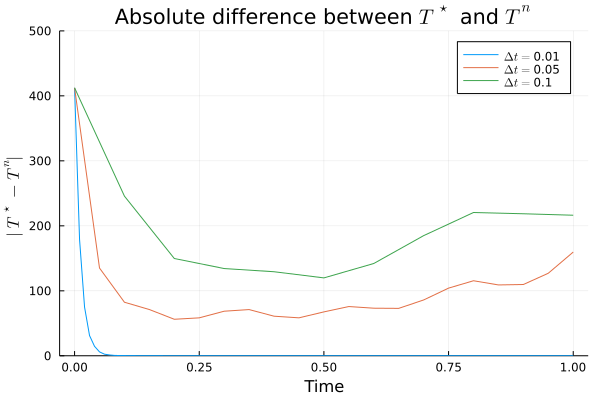

In [4]:
"""
Integrates the temperature field `T` with an initial velocity field `v` for `steps` steps with timestep `timestep`.

Returns an array containing all calculated temperature fields in fourier space.
"""
function integrate(geometry,timestep,steps,v,T,Q)
    Nx = geometry[1][1]
    Ny = geometry[1][2]
    Lx = geometry[2][1]
    Ly = geometry[2][2]


    T_hist = [fft(copy(T)),fft(copy(T))]
    v_hist = [copy(v)]
    hats = [v∇T(v_hist[end],real(ifft(T_hist[end - 1])),Nx,Ny,Lx,Ly)]
    Q = 


    for in in 1:steps
        # Calculate ℱ(v⋅∇T) #
        push!(hats,v∇T(v_hist[end],real(ifft(T_hist[end])),Nx,Ny,Lx,Ly))

        push!(T_hist,T_step(T_hist,v_hist,hats,Nx,Ny,Lx,Ly,timestep,Q))

        # Update velocity field #
        push!(v_hist,fft(update_velocity(T,Nx,Ny)))
    end

    return T_hist
end

function test_function(mode)
    Nx = 32
    Ny = 32
    Lx = 1.0
    Ly = 1.0

    geometry = ((Nx,Ny),(Lx,Ly))
    timestep = 0.002
    steps = 20
    
        # Initial temperature field #
        T = fill(0.0, (Nx,Ny))
        for i in 1:Nx
            for j in 1:Ny
                T[i,j] = 0
            end
        end
    

    if mode == "gif"
        anim = @animate for h in integrate(geometry,timestep,steps,velocity(Nx,Ny,Lx,Ly),T,Q_hat(Nx,Ny,Lx,Ly))
            #heatmap(real(ifft(h)),c= :magma)
            heatmap(real(ifft(h)))
        end every 100
        display(gif(anim, "heatmap.gif",fps=15))
    end


    # Plot maximum temperature to find stationaty solution #
    if mode == "max"
        maxx = []
        for h in integrate(geometry,timestep,steps,velocity(Nx,Ny,Lx,Ly),T,Q_hat(Nx,Ny,Lx,Ly))
            append!(maxx,maximum(real(ifft(h))))
        end
        display(plot(maxx))
    end
    Q = Q_hat(Nx,Ny,Lx,Ly)
    if mode == "v"
        # Initial velocity field #
        v = Matrix{Vector{Float64}}(undef, Nx, Ny)
        for i in 1:Nx
            for j in 1:Ny
                v[i,j] = copy([0.0,0.0])
                v[i,j][1] = pi*sin(4*pi*(Lx/(Nx))*(i))*cos(2*pi*(Ly/(Ny))*((j)))
                v[i,j][2] = -2*pi*cos(4*pi*(Lx/(Nx))*(i))*sin(2*pi*(Ly/(Ny))*((j)))
            end
        end
        #v[1,1][1] = 50
        plotx = heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),getindex.(v',1),title=L"$\vec{v}_y$",xlabel=L"$x$",ylabel=L"$y$",aspect_ratio=:equal,clim = (-5, 5))
        ploty = heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),getindex.(v',2),title=L"$\vec{v}_x$",xlabel=L"$x$",ylabel=L"$y$",aspect_ratio=:equal,clim = (-5, 5))
        display(plot(ploty,plotx,size=(800,400),link=:all,layout=(1,2),sharey = true, legend=:none))
    end

    if mode == "roc"
        cc = []
        t_max = 1
        timesteps = [0.01 0.05 0.1]
        plt_absolute = plot()
        plt_change = plot()
        for i in timesteps'
            diff_t_star = []
            change = []
            steps = floor(t_max/i)
            T_hist = integrate(geometry,i,steps,velocity(Nx,Ny,Lx,Ly),T,Q_hat(Nx,Ny,Lx,Ly))
            for i in 2:length(T_hist)
                push!(change,abs_change(real(ifft(T_hist[i])),real(ifft(T_hist[i-1]))))
                push!(diff_t_star,sum(abs.(real(ifft(T_hist[i])) - target_T(Nx,Ny,Lx,Ly)))) 
            end
            plt_change = plot!(plt_change,(0:i:steps*i),change,label=L"$\Delta t = $" .* string.(i),ylim=(0,100),xlabel="Time",ylabel=L"$\sum_{ij}\vert T_{ij}^n-T_{ij}^{n-1}\vert$",title=L"Absolute difference between $T^{n}$ and $T^{n-1}$")
            plt_absolute = plot!(plt_absolute,(0:i:steps*i),diff_t_star,label=L"$\Delta t = $" .* string.(i),ylim=(0,500),xlabel="Time",ylabel=L"$\vert T^\star- T^n \vert$",title=L"Absolute difference between $T^\star$ and $T^{n}$")
            #push!(cc,plot((0:i:steps*i),c,label=L"$\Delta t = $" .* string.(i),ylim=(0,100),xlabel="Timesteps",ylabel=L"$\sum_{ij}\vert T_{ij}^n-T_{ij}^{n-1}\vert$"))


        end
        display(plot(plt_absolute))
    end


    #Sum of the absolute diffrence between temperature field $T^n$ and $T^{n-1}$
    if mode == "Q"
        display(heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),real(ifft(Q))',title=L"Source term $Q^\star$",aspect_ratio=:equal,xlabel=L"$x$",ylabel=L"$y$",size=(600,600)))
        #Q_NEW = fft(real(ifft(Q)))

        #display(heatmap(real(ifft(Q_NEW))))
    end

    if mode == "final"
        T = real(ifft(integrate(geometry,timestep,steps,velocity(Nx,Ny,Lx,Ly),T,Q_hat(Nx,Ny,Lx,Ly))[end]))'
        display(heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),T,title=L"$T$ after " * string(steps) * " time steps",aspect_ratio=:equal,xlabel=L"$x$",ylabel=L"$y$",size=(600,600)))
        print(maximum(T))
    end

    if mode == "test"
        T = real(ifft(integrate(geometry,timestep,steps,velocity(Nx,Ny,Lx,Ly),T,Q_hat(Nx,Ny,Lx,Ly))[end]))
        v = velocity(Nx,Ny,Lx,Ly)

        OO = real(ifft(v∇T(v,T,Nx,Ny,Lx,Ly))) - laplace(T,Nx,Ny,Lx,Ly) - real(ifft(Q))
        
        display(heatmap(target_T(Nx,Ny,Lx,Ly) - T,aspect_ratio=:equal,right_margin = 10Plots.mm))
        #display(heatmap(target_T(Nx,Ny,Lx,Ly) - T,aspect_ratio=:equal,right_margin = 10Plots.mm))
    end
end
test_function("roc")



## Task 6

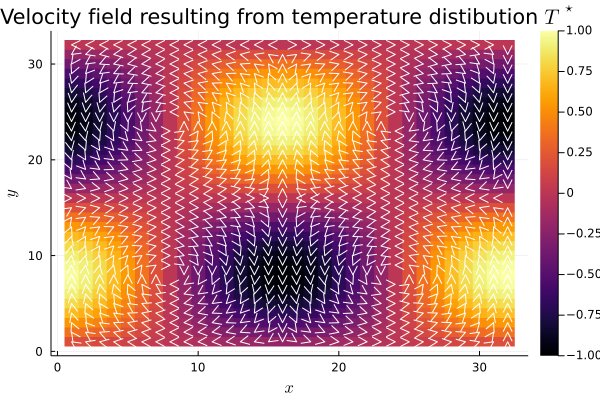

In [19]:
"""
Updates the velocity field for a given `T` in fourier space.

Returns velocity vector field in fourier space. 
"""
function update_velocity(T,Nx,Ny)
    v = Matrix{Vector{ComplexF64}}(undef, Nx, Ny)
    kx = 2*pi*fftfreq(Nx)*Nx
    ky = 2*pi*fftfreq(Ny)*Ny
    k_abs = kx.^2 .+ (ky.^2)'
    Ra = 1
    for i in 1:Nx
        for j in 1:Ny
            v[i,j] = copy([0.0,0.0])
            if k_abs[i,j] != 0
                v[i,j][1] = ((-kx[i]*ky[j]/k_abs[i,j])*T[i,j]*Ra)/(k_abs[i,j])
                v[i,j][2] = ((-ky[j]*ky[j]/k_abs[i,j] + 1)*T[i,j]*Ra)/(k_abs[i,j])
            end
        end
    end
    return v
end

function test_v_update()
    Nx = 32
    Ny = 32
    Lx = 1.0
    Ly = 1.0
    vx = real(ifft(getindex.(update_velocity(fft(target_T(Nx,Ny,Lx,Ly)),Nx,Ny),1)))
    vy = real(ifft(getindex.(update_velocity(fft(target_T(Nx,Ny,Lx,Ly)),Nx,Ny),2)))
    
    #vx,vy = normalize(vx,vy)
    
    xs = 1:Nx
    ys = 1:Ny
    
    xxs = [x for x in xs for y in ys]
    yys = [y for x in xs for y in ys]
    
    
    
    heatmap(xs,ys,target_T(Nx,Ny,Lx,Ly)')
    #GRUtils.quiver(x,y,vy,vx)
    #GRUtils.heatmap(target_T(Nx,Ny,Lx,Ly))
    #heatmap(vy)
    Plots.quiver!(vec(xxs),vec(yys),quiver=(vec(vx'),vec(vy')),color=:white,title=L"Velocity field resulting from temperature distibution $T^\star$",xlabel=L"$x$",ylabel=L"$y$")    
end
test_v_update()

In [20]:
function source_distribution(i,j,Nx,Ny,Lx,Ly,σ)
    x = Lx/Nx * i
    y = Ly/Ny * j
    return 1/(2*pi*σ^2)*exp(-((x-0.5*Lx)^2 + y^2)/(2*σ^2))
end

function integrate_dynamic_velocity(geometry,timestep,steps,v,T)
    Nx = geometry[1][1]
    Ny = geometry[1][2]
    Lx = geometry[2][1]
    Ly = geometry[2][2]


    T_hist = [fft(copy(T)),fft(copy(T))]
    v_hist = [copy(v)]
    hats = [v∇T(v_hist[end],real(ifft(T_hist[end - 1])),Nx,Ny,Lx,Ly)]
    Q = Q_hat(Nx,Ny,Lx,Ly)

    for in in 1:steps
        push!(T_hist,T_step(T_hist,v_hist,hats,Nx,Ny,Lx,Ly,timestep,Q))
    end

    return T_hist
end


source_distribution (generic function with 1 method)

In [407]:
Nx = 32
Ny = 32
kx = 2*pi*fftfreq(Nx)*Nx
ky = 2*pi*fftfreq(Ny)*Ny
k_abs = kx.^2 .+ (ky.^2)'

32×32 Matrix{Float64}:
    0.0       39.4784   157.914   355.306  …   355.306   157.914    39.4784
   39.4784    78.9568   197.392   394.784      394.784   197.392    78.9568
  157.914    197.392    315.827   513.219      513.219   315.827   197.392
  355.306    394.784    513.219   710.612      710.612   513.219   394.784
  631.655    671.133    789.568   986.96       986.96    789.568   671.133
  986.96    1026.44    1144.87   1342.27   …  1342.27   1144.87   1026.44
 1421.22    1460.7     1579.14   1776.53      1776.53   1579.14   1460.7
 1934.44    1973.92    2092.36   2289.75      2289.75   2092.36   1973.92
 2526.62    2566.1     2684.53   2881.92      2881.92   2684.53   2566.1
 3197.75    3237.23    3355.67   3553.06      3553.06   3355.67   3237.23
 3947.84    3987.32    4105.76   4303.15   …  4303.15   4105.76   3987.32
 4776.89    4816.37    4934.8    5132.19      5132.19   4934.8    4816.37
 5684.89    5724.37    5842.81   6040.2       6040.2    5842.81   5724.37
    ⋮     

    Updating registry at `/opt/julia/registries/General.toml`
   Resolving package versions...
   Installed GRUtils ─ v0.7.2
    Updating `/opt/julia/environments/v1.7/Project.toml`
  [0337cf30] + GRUtils v0.7.2
    Updating `/opt/julia/environments/v1.7/Manifest.toml`
  [0337cf30] + GRUtils v0.7.2
Precompiling project...
  ✓ GRUtils
  1 dependency successfully precompiled in 11 seconds (238 already precompiled)
